<a href="https://colab.research.google.com/github/KeisukeShimokawa/papers-challenge/blob/master/src/gan/FQGAN/notebooks/FQGAN_with_ResBlock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```js
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
```

## download

In [0]:
!rm -rf *.txt
!rm -rf logs

In [2]:
!nvidia-smi | head -n 10

Sun May 24 05:33:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+


In [0]:
!mkdir -p data
!wget -q https://www.dropbox.com/s/j6tp062e14gg5yc/img_align_celeba.zip -O data/celeba.zip
!unzip -q -o -d ./data data/celeba.zip
!rm -rf data/celeba.zip

In [4]:
!ls data

img_align_celeba


In [0]:
import os
import sys
import time
import random
import dataclasses
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from logging import getLogger, StreamHandler, FileHandler, INFO, Formatter

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Function, Variable
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torchsummary import summary

In [0]:
# avoid error
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [0]:
class Logger:
    def __init__(self, log_dir, flush_secs):

        self.log_dir = Path(log_dir)
        self.flush_secs = flush_secs
        self.logger = self._build_logger()
        self.writers = {}

    def _build_logger(self):
        logger = getLogger("sample")
        logger.setLevel(INFO)
        # format
        fmt_str = "[%(levelname)s] %(asctime)s: \t%(message)s"
        fmt = Formatter(fmt_str, "%Y-%m-%d %H-%M-%S")
        # stream handler
        stm_handler = StreamHandler(sys.stdout)
        stm_handler.setLevel(INFO)
        stm_handler.setFormatter(fmt)
        # file handler
        file_handler = FileHandler("logs.txt")
        file_handler.setLevel(INFO)
        file_handler.setFormatter(fmt)
        # add handler to logger
        logger.addHandler(stm_handler)
        logger.addHandler(file_handler)

        return logger

    def print_log(self, message):
        self.logger.info(message)

    def _build_writer(self, metrics):
        writer = SummaryWriter(
            log_dir=self.log_dir.joinpath("data", metrics),
            flush_secs=self.flush_secs
        )
        return writer

    def add_scalar(self, metrics, value, global_step=None):
        if metrics not in self.writers:
            self.writers[metrics] = self._build_writer(metrics)

        self.writers[metrics].add_scalar(metrics, value, global_step)

    def add_image(self, tag, tensor, global_step=None):
        n = min(tensor.size(0), 36)
        image_tensor = make_grid(tensor[:n], nrow=6, padding=2, normalize=True)

        if tag not in self.writers:
            self.writers[tag] = self._build_writer(tag)

        self.writers[tag].add_image(tag, image_tensor, global_step)

    def add_histogram(self, tag, tensor, global_step=None):

        if tag not in self.writers:
            self.writers[tag] = self._build_writer(tag)

        self.writers[tag].add_histogram(tag, tensor, global_step)

    def add_embedding(self, tag, emb_mat, global_step=None):
        mat = emb_mat.transpose(0, 1)

        if tag not in self.writers:
            self.writers[tag] = self._build_writer(tag)

        self.writers[tag].add_embedding(mat, global_step=global_step)

    def close_writers(self):
        for metrics in self.writers:
            self.writers[metrics].close()

## configuration

In [0]:
@dataclasses.dataclass
class Config:
    # general settings
    seed: int = 42
    ngpu: int = 1
    
    # dataset
    datapath: str = "data/"
    num_workers: int = 2
    image_size: int = 64

    # model
    nc: int = 3
    nz: int = 128
    ngf: int = 768
    ndf: int = 768
    use_sn: bool = True
    use_cbm: bool = True
    use_vq: bool = False
    dict_size: int = 5 # 2^10 --> 1024
    bottom_width: int = 4

    # training
    n_epochs: int = 30
    batch_size: int = 128
    beta1: float = 0.0
    beta2: float = 0.9
    lrD: float = 1e-4
    lrG: float = 1e-4
    is_ortho: bool = False
    factor: float = 1e-4
    loss_type: str = "bce"

    # logging
    log_dir: str = "logs"
    flush_secs: int = 5
    print_iters: int = 200

    @property
    def betas(self):
        return (self.beta1, self.beta2)

    @property
    def is_cuda(self):
        return self.ngpu > 0 and torch.cuda.is_available()

    @property
    def device(self):
        return torch.device("cuda:0" if self.is_cuda else "cpu")

    def __repr__(self):
        msg = "\n"
        for key, value in self.__dict__.items():
            msg += f"{key}: {value}\n"
        return msg

In [0]:
# set configuraition
cfg = Config()

In [10]:
logger = Logger(cfg.log_dir, cfg.flush_secs)

logger.print_log(f"configuration: {cfg}")

[INFO] 2020-05-24 05-38-57: 	configuration: 
seed: 42
ngpu: 1
datapath: data/
num_workers: 2
image_size: 64
nc: 3
nz: 128
ngf: 768
ndf: 768
use_sn: True
use_cbm: True
use_vq: False
dict_size: 5
bottom_width: 4
n_epochs: 30
batch_size: 128
beta1: 0.0
beta2: 0.9
lrD: 0.0001
lrG: 0.0001
is_ortho: False
factor: 0.0001
loss_type: bce
log_dir: logs
flush_secs: 5
print_iters: 200



In [0]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [12]:
if cfg.seed:
    set_seed(cfg.seed)
    logger.print_log(f"set random seed: {cfg.seed}")

[INFO] 2020-05-24 05-38-57: 	set random seed: 42


In [13]:
logger.print_log(f"device setting: {cfg.device}")

[INFO] 2020-05-24 05-38-58: 	device setting: cuda:0


## dataset

In [14]:
dataset = datasets.ImageFolder(
    root=cfg.datapath,
    transform=transforms.Compose([
        transforms.Resize(cfg.image_size),
        transforms.CenterCrop(cfg.image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

dataloader = DataLoader(
    dataset, 
    batch_size=cfg.batch_size,
    shuffle=True, 
    num_workers=cfg.num_workers
)

logger.print_log(f"dataset size: {len(dataset)}")

[INFO] 2020-05-24 05-38-58: 	dataset size: 202599


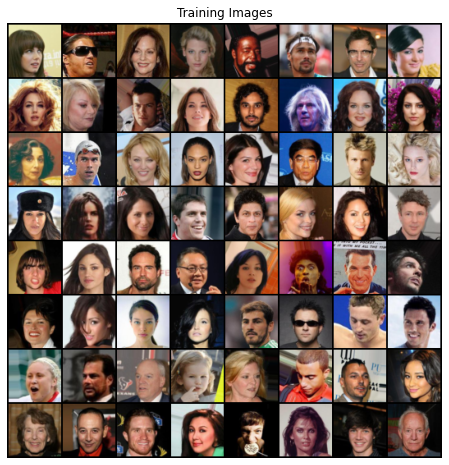

In [15]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        make_grid(real_batch[0].to(cfg.device)[:64], normalize=True).cpu(),
        (1,2,0)
    )
)

In [16]:
logger.print_log(f"sample real batch size: {real_batch[0].size()}")
logger.add_image("sample", real_batch[0])

[INFO] 2020-05-24 05-39-15: 	sample real batch size: torch.Size([128, 3, 64, 64])


## model

In [0]:
import math

In [0]:
def SNConv2d(use_sn, *args, **kwargs):
    if use_sn:
        return torch.nn.utils.spectral_norm(nn.Conv2d(*args, **kwargs))
    else:
        return nn.Conv2d(*args, **kwargs)

In [0]:
def SNLinear(use_sn, *args, **kwargs):
    if use_sn:
        return torch.nn.utils.spectral_norm(nn.Linear(*args, **kwargs))
    else:
        return nn.Linear(*args, **kwargs)

In [0]:
def SNEmbedding(use_sn, *args, **kwargs):
    if use_sn:
        return torch.nn.utils.spectral_norm(nn.Embedding(*args, **kwargs))
    else:
        return nn.Embedding(*args, **kwargs)

In [0]:
def SNConvTranspose2d(use_sn, *args, **kwargs):
    if use_sn:
        return torch.nn.utils.spectral_norm(nn.ConvTranspose2d(*args, **kwargs))
    else:
        return nn.ConvTranspose2d(*args, **kwargs)

In [0]:
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight_data[:, :num_features].normal_(1, 0.02)
        self.embed.weight_data[:, num_features:].zero_()

    def forward(self, x, y):
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, 1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + \
               beta.view(-1, self.num_features, 1, 1)

        return out

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class GBlock(nn.Module):

    def __init__(self, in_channels, out_channels, hidden_channels=None, 
                 upsample=False, num_classes=0, use_sn=False):
        super(GBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels if hidden_channels is not None else out_channels
        self.learnable_sc = in_channels != out_channels or upsample
        self.upsample = upsample
        self.num_classes = num_classes
        self.use_sn = use_sn

        self.c1 = SNConv2d(use_sn, self.in_channels,     self.hidden_channels, 3, 1, 1)
        self.c2 = SNConv2d(use_sn, self.hidden_channels, self.out_channels,    3, 1, 1)

        if self.num_classes == 0:
            self.b1 = nn.BatchNorm2d(self.in_channels)
            self.b2 = nn.BatchNorm2d(self.hidden_channels)
        else:
            self.b1 = ConditionalBatchNorm2d(self.in_channels, self.num_classes)
            self.b2 = ConditionalBatchNorm2d(self.hidden_channels, self.num_classes)

        self.activation = nn.ReLU(True)

        nn.init.xavier_uniform_(self.c1.weight.data, math.sqrt(2.0))
        nn.init.xavier_uniform_(self.c2.weight.data, math.sqrt(2.0))

        # Shortcut layer
        if self.learnable_sc:
            self.c_sc = SNConv2d(use_sn, self.in_channels, self.out_channels, 1, 1, 0)
            nn.init.xavier_uniform_(self.c_sc.weight.data, 1.0)

    def _upsample_conv(self, x, conv):

        return conv(F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False))

    def _residual(self, x, y=None):

        h = x
        h = self.b1(h) if y is None else self.b1(h, y)
        h = self.activation(h)
        h = self._upsample_conv(h, self.c1) if self.upsample else self.c1(h)
        h = self.b2(h) if y is None else self.b1(h, y)
        h = self.activation(h)
        h = self.c2(h)

        return h

    def _shortcut(self, x):

        if self.learnable_sc:
            x = self._upsample_conv(x, self.c_sc) if self.upsample else self.c_sc(x)

        return x

    def forward(self, x, y=None):

        return self._residual(x, y) + self._shortcut(x)

In [25]:
GBlock(32, 64, 64, False, 0, True)(torch.randn(10, 32, 64, 64)).shape

torch.Size([10, 64, 64, 64])

In [26]:
GBlock(32, 64, 64, True, 0, True)(torch.randn(10, 32, 64, 64)).shape

torch.Size([10, 64, 128, 128])

In [0]:
class DBlockOptimized(nn.Module):

    def __init__(self, in_channels, out_channels, use_sn=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.use_sn = use_sn

        # Build Layers
        self.c1   = SNConv2d(use_sn, self.in_channels,  self.out_channels, 3, 1, 1)
        self.c2   = SNConv2d(use_sn, self.out_channels, self.out_channels, 3, 1, 1)
        self.c_sc = SNConv2d(use_sn, self.in_channels,  self.out_channels, 1, 1, 0)

        self.activation = nn.ReLU(True)

        nn.init.xavier_uniform_(self.c1.weight.data, math.sqrt(2.0))
        nn.init.xavier_uniform_(self.c2.weight.data, math.sqrt(2.0))
        nn.init.xavier_uniform_(self.c_sc.weight.data, 1.0)

    def _residual(self, x):

        h = x
        h = self.c1(h)
        h = self.activation(h)
        h = self.c2(h)
        h = F.avg_pool2d(h, 2)

        return h

    def _shortcut(self, x):

        return self.c_sc(F.avg_pool2d(x, 2))

    def forward(self, x):

        return self._residual(x) + self._shortcut(x)

In [28]:
DBlockOptimized(3, 32, True)(torch.randn(10, 3, 64, 64)).shape

torch.Size([10, 32, 32, 32])

In [0]:
class DBlock(nn.Module):

    def __init__(self, in_channels, out_channels, hidden_channels=None,
                 downsample=False, use_sn=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels if hidden_channels is not None else in_channels
        self.downsample = downsample
        self.learnable_sc = (in_channels != out_channels) or downsample
        self.use_sn = use_sn

        self.c1 = SNConv2d(use_sn, self.in_channels,     self.hidden_channels, 3, 1, 1)
        self.c2 = SNConv2d(use_sn, self.hidden_channels, self.out_channels,    3, 1, 1)
        self.activation = nn.ReLU(True)

        nn.init.xavier_uniform_(self.c1.weight.data, math.sqrt(2.0))
        nn.init.xavier_uniform_(self.c2.weight.data, math.sqrt(2.0))

        # Shortcut layer
        if self.learnable_sc:
            self.c_sc = SNConv2d(use_sn, self.in_channels, self.out_channels, 1, 1, 0)
            nn.init.xavier_uniform_(self.c_sc.weight.data, 1.0)

    def _residual(self, x):

        h = x
        h = self.activation(h)
        h = self.c1(h)
        h = self.activation(h)
        h = self.c2(h)
        if self.downsample:
            h = F.avg_pool2d(h, 2)

        return h

    def _shortcut(self, x):
 
        if self.learnable_sc:
            x = self.c_sc(x)
            if self.downsample: x = F.avg_pool2d(x, 2) 

        return x

    def forward(self, x):

        return self._residual(x) + self._shortcut(x)

In [30]:
DBlock(32, 64, 64, False, True)(torch.randn(10, 32, 64, 64)).shape

torch.Size([10, 64, 64, 64])

In [31]:
DBlock(32, 64, 64, True, True)(torch.randn(10, 32, 64, 64)).shape

torch.Size([10, 64, 32, 32])

### Generator

In [0]:
class ResNetGenerator(nn.Module):

    def __init__(self, nz, ngf, nc, bottom_width=4, use_sn=True):
        super(ResNetGenerator, self).__init__()
        self.nz = nz
        self.ngf = ngf
        self.nc = nc
        self.bottom_width = bottom_width

        # [B, nz] --> [B, (width*width)*ngf] --> [B, ngf, width, width]
        self.l1 = SNLinear(use_sn, self.nz, (self.bottom_width**2)*self.ngf)          
        self.block2 = GBlock(self.ngf,      self.ngf >> 1, upsample=True, use_sn=use_sn)
        self.block3 = GBlock(self.ngf >> 1, self.ngf >> 2, upsample=True, use_sn=use_sn)
        self.block4 = GBlock(self.ngf >> 2, self.ngf >> 3, upsample=True, use_sn=use_sn)
        self.block5 = GBlock(self.ngf >> 3, self.ngf >> 4, upsample=True, use_sn=use_sn)
        self.b6 = nn.BatchNorm2d(self.ngf >> 4)
        self.c6 = SNConv2d(use_sn, self.ngf >> 4, self.nc, kernel_size=3, stride=1, padding=1)
        self.activation = nn.ReLU(True)

        # Initialise the weights
        nn.init.xavier_uniform_(self.l1.weight.data, 1.0)
        nn.init.xavier_uniform_(self.c6.weight.data, 1.0)

    def forward(self, x):
        h = self.l1(x)
        # [B, ngf, 4,  4]
        h = h.view(x.size(0), -1, self.bottom_width, self.bottom_width)
        h = self.block2(h) # [B, ngf//2,   8,  8]
        h = self.block3(h) # [B, ngf//4,  16, 16]
        h = self.block4(h) # [B, ngf//8,  32, 32]
        h = self.block5(h) # [B, ngf//16, 64, 64]
        h = self.b6(h)
        h = self.activation(h)
        h = torch.tanh(self.c6(h)) # [B, 3, 64, 64]

        return h

    def sample_latent(self, batch_size):
        return torch.randn((batch_size, self.nz))

    def generate_images(self, num_images, device=None):
        assert device is not None, "please set device setting"

        noise = self.sample_latent((num_images)).to(device)
        fake_images = self.forward(noise)

        return fake_images

In [33]:
ResNetGenerator(100, 1024, 3, 4, True)(torch.randn(100, 100)).shape

torch.Size([100, 3, 64, 64])

In [34]:
ResNetGenerator(100, 1024, 3, 4, True).sample_latent(100).shape

torch.Size([100, 100])

In [35]:
ResNetGenerator(100, 1024, 3, 4, True).generate_images(100, "cpu").shape

torch.Size([100, 3, 64, 64])

In [36]:
ResNetGenerator(100, 1024, 3, 4, False).generate_images(100, "cpu").shape

torch.Size([100, 3, 64, 64])

In [37]:
# Create the generator
netG = ResNetGenerator(cfg.nz, cfg.ngf, cfg.nc, cfg.bottom_width, cfg.use_sn).to(cfg.device)

# Handle multi-gpu if desired
if (cfg.is_cuda) and (cfg.ngpu > 1):
    netG = nn.DataParallel(netG, list(range(cfg.ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

summary(netG, (cfg.nz, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 12288]       1,585,152
       BatchNorm2d-2            [-1, 768, 4, 4]           1,536
              ReLU-3            [-1, 768, 4, 4]               0
            Conv2d-4            [-1, 384, 8, 8]       2,654,592
       BatchNorm2d-5            [-1, 384, 8, 8]             768
              ReLU-6            [-1, 384, 8, 8]               0
            Conv2d-7            [-1, 384, 8, 8]       1,327,488
            Conv2d-8            [-1, 384, 8, 8]         295,296
            GBlock-9            [-1, 384, 8, 8]               0
      BatchNorm2d-10            [-1, 384, 8, 8]             768
             ReLU-11            [-1, 384, 8, 8]               0
           Conv2d-12          [-1, 192, 16, 16]         663,744
      BatchNorm2d-13          [-1, 192, 16, 16]             384
             ReLU-14          [-1, 192,

In [38]:
netG

ResNetGenerator(
  (l1): Linear(in_features=128, out_features=12288, bias=True)
  (block2): GBlock(
    (c1): Conv2d(768, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b1): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (b2): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU(inplace=True)
    (c_sc): Conv2d(768, 384, kernel_size=(1, 1), stride=(1, 1))
  )
  (block3): GBlock(
    (c1): Conv2d(384, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (b2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU(inplace=True)
    (c_sc): Conv2d(384, 192, kernel_size=(1, 1), stride=(1, 1)

### Feature Quantization for GAN Training

In [0]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, emb_dim, num_emb, commitment=0.25, decay=0.99, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self.emb_dim = emb_dim
        self.num_emb = num_emb
        self.commitment = commitment
        self.decay = decay
        self.epsilon = epsilon

        embed = torch.randn(emb_dim, num_emb)
        self.register_buffer('embed', embed)
        self.register_buffer('cluster_size', torch.zeros(num_emb))
        self.register_buffer('ema_embed', embed.clone())
    
    def forward(self, inputs):
        # [B, C=D, H, W] --> [B, H, W, C=D]
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        inputs_shape = inputs.size()

        # flatten: [B, H, W, C=D] --> [BxHxW=N, D]
        flatten = inputs.view(-1, self.emb_dim)

        # distance: d(W[N, D], E[D, K]) <-- [N, K]
        distance = (
            flatten.pow(2).sum(1, keepdim=True)
            -2 * flatten @ self.embed
            + self.embed.pow(2).sum(0, keepdim=True)
        )

        # minimum index: [N, K] --> [N, ]
        embed_idx = torch.argmin(distance, dim=1)

        # set OneHot label: [N, ] --> [N, K]
        embed_onehot = F.one_hot(embed_idx, num_classes=self.num_emb).type(flatten.dtype)

        # quantize: [N, ] --> [B, H, W, ]
        embed_idx = embed_idx.view(*inputs_shape[:-1])
        # quantize: [B, H, W, ] embed [K, D] --> [B, H, W, D]
        quantize = F.embedding(embed_idx, self.embed.transpose(0, 1))
        quantize = quantize.view(*inputs_shape)

        # train embedding vector only when model.train() not model.eval()
        if self.training:
            # ref_counts: [N, K] --> [K, ]
            ref_counts = torch.sum(embed_onehot, dim=0)
            
            # ema for reference counts: [K, ]
            self.cluster_size.data.mul_(self.decay).add_(
                ref_counts, alpha=1-self.decay
            )

            # total reference count
            n = self.cluster_size.sum()

            # laplace smoothing
            smoothed_cluster_size = n * (
                (self.cluster_size + self.epsilon) / (n + self.cluster_size * self.epsilon)
            )

            # dw: [D, N] @ [N, K]
            dw = flatten.transpose(0, 1) @ embed_onehot

            # ema for embeddings: [D, K]
            self.ema_embed.data.mul_(self.decay).add_(
                dw, alpha=1-self.decay
            )

            # normalize by reference counts: [D, K] / [1, K] <-- [K, ]
            embed_normalized = self.ema_embed / smoothed_cluster_size.unsqueeze(0)
            # self.embed = self.ema_embed / self.cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)

        # loss
        e_latent_loss = F.mse_loss(quantize.detach(), inputs)
        # e_latent_loss = (quantize.detach() - inputs).pow(2).mean()
        loss = self.commitment * e_latent_loss

        # Straight Through Estimator
        quantize = inputs + (quantize - inputs).detach()
        # average probability: [N, K] --> [N, ]
        avg_probs = torch.mean(embed_onehot, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantize.permute(0, 3, 1, 2).contiguous(), loss, perplexity

### Discriminator

In [0]:
class ResNetDiscriminator(nn.Module):

    def __init__(self, nc, ndf, use_sn=False, use_vq=True, dict_size=5):
        super(ResNetDiscriminator, self).__init__()
        self.nc = nc
        self.ndf = ndf
        self.use_vq = use_vq
        self.dict_size = dict_size

        self.block1 = DBlockOptimized(self.nc, self.ndf >> 4, use_sn=use_sn)
        self.block2 = DBlock(self.ndf >> 4, self.ndf >> 3, downsample=True, use_sn=use_sn)
        self.block3 = DBlock(self.ndf >> 3, self.ndf >> 2, downsample=True, use_sn=use_sn)
        self.block4 = DBlock(self.ndf >> 2, self.ndf >> 1, downsample=True, use_sn=use_sn)
        self.block5 = DBlock(self.ndf >> 1, self.ndf,      downsample=True, use_sn=use_sn)
        self.l6 = SNLinear(use_sn, self.ndf, 1)
        self.activation = nn.ReLU(True)

        if self.use_vq:
            in_feat = self.ndf >> 2
            self.vq = VectorQuantizerEMA(in_feat, 2**self.dict_size)

        # Initialise the weights
        nn.init.xavier_uniform_(self.l6.weight.data, 1.0)

    def forward(self, x):

        h = x
        h = self.block1(h) # [B, ndf//16, 64, 64]
        h = self.block2(h) # [B, ndf//8,  32, 32]
        h = self.block3(h) # [B, ndf//4,  16, 16]
        if self.use_vq:
            h, loss, ppl = self.vq(h)
        h = self.block4(h) # [B, ndf//2,   8,  8]
        h = self.block5(h) # [B, ndf,      4,  4]
        h = self.activation(h)

        # Global average pooling
        h = torch.sum(h, dim=(2, 3))  # [B, ndf]
        output = self.l6(h).squeeze()

        if self.use_vq: return output, loss, ppl
        else:           return output, None, None

    def compute_probs(self, output_real, output_fake):
        D_x  = torch.sigmoid(output_real).mean().item()
        D_Gz = torch.sigmoid(output_fake).mean().item()

        return D_x, D_Gz

In [41]:
ResNetDiscriminator(3, 1024, True, True, 10)(torch.randn(10, 3, 64, 64))

(tensor([-0.1948, -0.1948, -0.1929, -0.1929, -0.1948, -0.1927, -0.1948, -0.1887,
         -0.1948, -0.1948], grad_fn=<SqueezeBackward0>),
 tensor(0.1883, grad_fn=<MulBackward0>),
 tensor(1.0467))

In [42]:
# Create the Discriminator
netD = ResNetDiscriminator(cfg.nc, cfg.ndf, cfg.use_sn, cfg.use_vq, cfg.dict_size).to(cfg.device)

# Handle multi-gpu if desired
if (cfg.is_cuda) and (cfg.ngpu > 1):
    netD = nn.DataParallel(netD, list(range(cfg.ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
# summary(netD, (cfg.nc, cfg.image_size, cfg.image_size))
netD

ResNetDiscriminator(
  (block1): DBlockOptimized(
    (c1): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c_sc): Conv2d(3, 48, kernel_size=(1, 1), stride=(1, 1))
    (activation): ReLU(inplace=True)
  )
  (block2): DBlock(
    (c1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU(inplace=True)
    (c_sc): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
  )
  (block3): DBlock(
    (c1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU(inplace=True)
    (c_sc): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
  )
  (block4): DBlock(
    (c1): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(192, 384, kernel_size=(3, 3), 

### Calculate Model Size

In [0]:
def count_parameters_float32(model):
    param = sum(p.numel() for p in model.parameters() if p.requires_grad)
    param_mb = param / 1024 / 1024 / 8 * 32
    return param, param_mb

In [44]:
paramG, memoryG = count_parameters_float32(netG)

logger.print_log(f"Generator: #of param: {paramG}, Memory: {memoryG:.2f} MB")

[INFO] 2020-05-24 05-39-50: 	Generator: #of param: 7272387, Memory: 27.74 MB


In [45]:
paramD, memoryD = count_parameters_float32(netD)

logger.print_log(f"Discriminator: #of param: {paramD}, Memory: {memoryD:.2f} MB")

[INFO] 2020-05-24 05-39-50: 	Discriminator: #of param: 5706049, Memory: 21.77 MB


## training settings

In [0]:
class ProbLoss(nn.Module):
    def __init__(self, cfg):
        assert cfg.loss_type in ["bce", "hinge"]
        super().__init__()
        self.loss_type = cfg.loss_type
        self.device = cfg.device
        self.ones = torch.ones(cfg.batch_size).to(cfg.device)
        self.zeros = torch.zeros(cfg.batch_size).to(cfg.device)
        self.bce = nn.BCEWithLogitsLoss()

    def __call__(self, logits, condition):
        assert condition in ["gen", "dis_real", "dis_fake"]
        batch_len = len(logits)

        if self.loss_type == "bce":
            if condition in ["gen", "dis_real"]:
                return self.bce(logits, self.ones[:batch_len])
            else:
                return self.bce(logits, self.zeros[:batch_len])

        elif self.loss_type == "hinge":     
            if condition == "gen":
                return -torch.mean(logits)
            elif condition == "dis_real":
                minval = torch.min(logits - 1, self.zeros[:batch_len])
                return -torch.mean(minval)
            else:
                minval = torch.min(-logits - 1, self.zeros[:batch_len])
                return -torch.mean(minval)

In [47]:
# Initialize BCELoss function
criterion = ProbLoss(cfg)

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, cfg.nz, device=cfg.device)
logger.print_log(f"fixed noise shape: {fixed_noise.size()}")

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=cfg.lrD, betas=cfg.betas)
optimizerG = optim.Adam(netG.parameters(), lr=cfg.lrG, betas=cfg.betas)

[INFO] 2020-05-24 05-39-50: 	fixed noise shape: torch.Size([64, 128])


In [0]:
def ortho_reg(model, factor=1e-4, device=None):
    with torch.enable_grad():
        ortho_loss = torch.tensor(0., device=device)
        for name, param in model.named_parameters():
            if "bias" not in name:
                w = param.view(param.size(0), -1)
                sym = ((w @ w.t()) * (1. - torch.eye(w.size(0), device=device)))
                ortho_loss += factor * sym.abs().sum()

    return ortho_loss

## Metrics

In [0]:
import os
import tarfile
from pathlib import Path
from urllib import request
import tensorflow as tf

In [0]:
def _check_or_download_inception(inception_path):

    # Build file path of model
    inception_url = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
    if inception_path is None:
        inception_path = '/tmp'
    inception_path = pathlib.Path(inception_path)
    model_file = inception_path / 'classify_image_graph_def.pb'

    # Download model if required
    if not model_file.exists():
        print("Downloading Inception model")
        fn, _ = request.urlretrieve(inception_url)

        with tarfile.open(fn, mode='r') as f:
            f.extract('classify_image_graph_def.pb', str(model_file.parent))

    return str(model_file)

In [0]:
def _get_inception_layer(sess):

    # Get the output node
    layer_name = 'inception_model/pool_3:0'
    pool3 = sess.graph.get_tensor_by_name(layer_name)

    # Reshape to be batch size agnostic
    ops = pool3.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if len(shape._dims) > 0:
                try:
                    shape = [s.value for s in shape]
                except AttributeError: # TF 2 uses None shape directly. No conversion needed.
                    shape = shape

                new_shape = []
                for j, s in enumerate(shape):
                    if s == 1 and j == 0:
                        new_shape.append(None)
                    else:
                        new_shape.append(s)
                o.__dict__['_shape_val'] = tf.TensorShape(new_shape)

    return pool3

In [0]:
def create_inception_graph(inception_path):

    Path(inception_path).mkdir(parents=True, exist_ok=True)

    # Get inception model file path
    model_file = _check_or_download_inception(inception_path)

    # Creates graph from saved graph_def.pb.
    with tf.gfile.GFile(model_file, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='inception_model')

In [0]:
def get_activations(images, sess, batch_size=50, verbose=True):
    """
    Calculates the activations of the pool_3 layer for all images.

    Returns:
        ndarray: Numpy array of shape (N, 2048) representing the pool3 features from the
        inception model.
    """
    # Get output layer.
    inception_layer = _get_inception_layer(sess)

    # Inference variables
    batch_size = min(batch_size, images.shape[0])
    num_batches = images.shape[0] // batch_size

    # Get features
    pred_arr = np.empty((images.shape[0], 2048))
    for i in range(num_batches):
        start_time = time.time()

        start = i * batch_size
        end = start + batch_size
        batch = images[start:end]
        pred = sess.run(inception_layer,
                        {'inception_model/ExpandDims:0': batch})
        pred_arr[start:end] = pred.reshape(batch_size, -1)

        if verbose:
            print("\rINFO: Propagated batch %d/%d (%.4f sec/batch)" \
                % (i+1, num_batches, time.time()-start_time), end="", flush=True)

    return pred_arr

In [0]:
def calculate_activation_statistics(images, sess, batch_size=50, verbose=True):
    """
    Calculation of the statistics used by the FID.
    Args:
        images (ndarray): Numpy array of shape (N, H, W, 3) and values in
            the range [0, 255].
        sess (Session): TensorFlow session object.
        batch_size (int): Batch size for inference.
        verbose (bool): If True, prints out logging information.
    Returns:
        ndarray: Mean of inception features from samples.
        ndarray: Covariance of inception features from samples.
    """
    act = inception_utils.get_activations(images, sess, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)

    return mu, sigma

In [0]:
from scipy import linalg

In [0]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):

    shape_check = mu1.shape != mu2.shape or sigma1.shape != sigma2.shape
    assert shape_check, "(mu1, sigma1) should have exactly the same shape as (mu2, sigma2)."

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        print(
            "WARNING: fid calculation produces singular product; adding {} to diagonal of cov estimates"
            .format(eps))
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(
        sigma2) - 2 * tr_covmean

In [0]:
from PIL import Image


def get_random_images(dataset, num_samples):
    choices = np.random.choice(range(len(dataset)), size=num_samples, replace=False)
    images = []
    for choice in choices:
        img = np.asarray(Image.open(dataset[choice][0]))
        img = np.expand_dims(img, axis=0)
        images.append(img)
    images = np.concatenate(images, axis=0)

    return images

In [0]:
def compute_real_dist_stats(num_samples,
                            sess,
                            dataset_name,
                            batch_size,
                            stats_file=None,
                            seed=0,
                            verbose=True,
                            log_dir='./log'):
    """
    Reads the image data and compute the FID mean and cov statistics
    for real images.
    Args:
        num_samples (int): Number of real images to compute statistics.
        sess (Session): TensorFlow session to use.
        dataset_name (str): The name of the dataset to load.
        batch_size (int): The batch size to feedforward for inference.
        stats_file (str): The statistics file to load from if there is already one.
        verbose (bool): If True, prints progress of computation.
        log_dir (str): Directory where feature statistics can be stored.
    Returns:
        ndarray: Mean features stored as np array.
        ndarray: Covariance of features stored as np array.
    """
    # Create custom stats file name
    if stats_file is None:
        stats_dir = os.path.join(log_dir, 'metrics', 'fid', 'statistics')
        if not os.path.exists(stats_dir):
            os.makedirs(stats_dir)

        stats_file = os.path.join(
            stats_dir,
            "fid_stats_{}_{}k_run_{}.npz".format(dataset_name,
                                                 num_samples // 1000, seed))

    if stats_file and os.path.exists(stats_file):
        print("INFO: Loading existing statistics for real images...")
        f = np.load(stats_file)
        m_real, s_real = f['mu'][:], f['sigma'][:]
        f.close()

    else:
        # Obtain the numpy format data
        print("INFO: Obtaining images...")
        images = get_dataset_images(dataset_name, num_samples=num_samples)

        # Compute the mean and cov
        print("INFO: Computing statistics for real images...")
        m_real, s_real = fid_utils.calculate_activation_statistics(
            images=images, sess=sess, batch_size=batch_size, verbose=verbose)

        if not os.path.exists(stats_file):
            print("INFO: Saving statistics for real images...")
            np.savez(stats_file, mu=m_real, sigma=s_real)

    return m_real, s_real

In [0]:
def _normalize_images(images):

    # Shift the image from [-1, 1] range to [0, 1] range.
    min_val = float(images.min())
    max_val = float(images.max())
    images.clamp_(min=min_val, max=max_val)
    images.add_(-min_val).div_(max_val - min_val + 1e-5)

    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    images = images.mul_(255).add_(0.5).clamp_(0, 255).permute(0, 2, 3, 1).to(
        'cpu', torch.uint8).numpy()
        
    return images

In [0]:
def compute_gen_dist_stats(netG,
                           num_samples,
                           sess,
                           device,
                           seed,
                           batch_size,
                           print_every=20,
                           verbose=True):
    """
    Directly produces the images and convert them into numpy format without
    saving the images on disk.
    Args:
        netG (Module): Torch Module object representing the generator model.
        num_samples (int): The number of fake images for computing statistics.
        sess (Session): TensorFlow session to use.
        device (str): Device identifier to use for computation.
        seed (int): The random seed to use.
        batch_size (int): The number of samples per batch for inference.
        print_every (int): Interval for printing log.
        verbose (bool): If True, prints progress.
    Returns:
        ndarray: Mean features stored as np array.
        ndarray: Covariance of features stored as np array.
    """
    with torch.no_grad():
        # Set model to evaluation mode
        netG.eval()

        # Inference variables
        batch_size = min(num_samples, batch_size)

        # Collect all samples()
        images = []
        start_time = time.time()
        for idx in range(num_samples // batch_size):
            # Collect fake image
            fake_images = netG.generate_images(num_images=batch_size,
                                               device=device).detach().cpu()
            images.append(fake_images)

            # Print some statistics
            if (idx + 1) % print_every == 0:
                end_time = time.time()
                print(
                    "INFO: Generated image {}/{} [Random Seed {}] ({:.4f} sec/idx)"
                    .format(
                        (idx + 1) * batch_size, num_samples, seed,
                        (end_time - start_time) / (print_every * batch_size)))
                start_time = end_time

        # Produce images in the required (N, H, W, 3) format for FID computation
        images = torch.cat(images, 0)  # Gives (N, 3, H, W)
        images = _normalize_images(images)  # Gives (N, H, W, 3)

    # Compute the FID
    print("INFO: Computing statistics for fake images...")
    m_fake, s_fake = fid_utils.calculate_activation_statistics(
        images=images, sess=sess, batch_size=batch_size, verbose=verbose)

    return m_fake, s_fake

In [0]:
def fid_score(num_real_samples,
              num_fake_samples,
              netG,
              device,
              seed,
              dataset_name,
              batch_size=50,
              verbose=True,
              stats_file=None,
              log_dir='./log'):
    """
    Computes FID stats using functions that store images in memory for speed and fidelity.
    Fidelity since by storing images in memory, we don't subject the scores to different read/write
    implementations of imaging libraries.
    Args:
        num_real_samples (int): The number of real images to use for FID.
        num_fake_samples (int): The number of fake images to use for FID.
        netG (Module): Torch Module object representing the generator model.
        device (str): Device identifier to use for computation.
        seed (int): The random seed to use.
        dataset_name (str): The name of the dataset to load.
        batch_size (int): The batch size to feedforward for inference.
        verbose (bool): If True, prints progress.
        stats_file (str): The statistics file to load from if there is already one.
        log_dir (str): Directory where feature statistics can be stored.
    Returns:
        float: Scalar FID score.
    """
    start_time = time.time()

    # Make sure the random seeds are fixed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Setup directories
    inception_path = os.path.join(log_dir, 'metrics', 'inception_model')

    # Setup the inception graph
    inception_utils.create_inception_graph(inception_path)

    # Start producing statistics for real and fake images
    if device and device.index is not None:
        # Avoid unbounded memory usage
        gpu_options = tf.GPUOptions(allow_growth=True,
                                    per_process_gpu_memory_fraction=0.15,
                                    visible_device_list=str(device.index))
        config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)

    else:
        config = tf.compat.v1.ConfigProto(device_count={'GPU': 0})

    with tf.compat.v1.Session(config=config) as sess:
        sess.run(tf.compat.v1.global_variables_initializer())

        m_real, s_real = compute_real_dist_stats(num_samples=num_real_samples,
                                                 sess=sess,
                                                 dataset_name=dataset_name,
                                                 batch_size=batch_size,
                                                 verbose=verbose,
                                                 stats_file=stats_file,
                                                 log_dir=log_dir,
                                                 seed=seed)

        m_fake, s_fake = compute_gen_dist_stats(netG=netG,
                                                num_samples=num_fake_samples,
                                                sess=sess,
                                                device=device,
                                                seed=seed,
                                                batch_size=batch_size,
                                                verbose=verbose)

        FID_score = fid_utils.calculate_frechet_distance(mu1=m_real,
                                                         sigma1=s_real,
                                                         mu2=m_fake,
                                                         sigma2=s_fake)

        print("INFO: FID Score: {} [Time Taken: {:.4f} secs]".format(
            FID_score,
            time.time() - start_time))

        return float(FID_score)

In [0]:
def evaluate(metric,
             netG,
             log_dir,
             evaluate_range=None,
             evaluate_step=None,
             num_runs=3,
             start_seed=0,
             overwrite=False,
             write_to_json=True,
             device=None,
             **kwargs):
    """
    Evaluates a generator over several runs.
    Args:
        metric (str): The name of the metric for evaluation.
        netG (Module): Torch generator model to evaluate.
        log_dir (str): The path to the log directory.
        evaluate_range (tuple): The 3 valued tuple for defining a for loop.
        evaluate_step (int): The specific checkpoint to load. Used in place of evaluate_range.
        device (str): Device identifier to use for computation.
        num_runs (int): The number of runs to compute FID for each checkpoint.
        start_seed (int): Starting random seed to use.
        write_to_json (bool): If True, writes to an output json file in log_dir.
        overwrite (bool): If True, then overwrites previous metric score.
    Returns:
        None
    """
    if metric == 'kid':
        if 'num_subsets' not in kwargs or 'subset_size' not in kwargs:
            raise ValueError(
                "num_subsets and subset_size must be provided for KID computation.")

    elif metric == 'fid':
        if 'num_real_samples' not in kwargs or 'num_fake_samples' not in kwargs:
            raise ValueError(
                "num_real_samples and num_fake_samples must be provided for FID computation.")

    elif metric == 'inception_score':
        if 'num_samples' not in kwargs:
            raise ValueError("num_samples must be provided for IS computation.")

    else:
        choices = ['fid', 'kid', 'inception_score']
        raise ValueError("Invalid metric {} selected. Choose from {}.".format(metric, choices))

    if evaluate_range and evaluate_step or not (evaluate_step
                                                or evaluate_range):
        raise ValueError(
            "Only one of evaluate_step or evaluate_range can be defined.")

    if evaluate_range:
        if (type(evaluate_range) != tuple
                or not all(map(lambda x: type(x) == int, evaluate_range))):
            raise ValueError(
                "evaluate_range must be a tuple of ints (start, end, step).")

    ckpt_dir = os.path.join(log_dir, 'checkpoints', 'netG')

    if not os.path.exists(ckpt_dir):
        raise ValueError(
            "Checkpoint directory {} cannot be found in log_dir.".format(
                ckpt_dir))

    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Decide naming convention
    names_dict = {
        'fid': 'FID',
        'inception_score': 'Inception Score',
        'kid': 'KID',
    }

    # Set output file and restore if available.
    if metric == 'fid':
        output_file = os.path.join(
            log_dir,
            'fid_{}k_{}k.json'.format(kwargs['num_real_samples'] // 1000,
                                      kwargs['num_fake_samples'] // 1000))

    elif metric == 'inception_score':
        output_file = os.path.join(
            log_dir,
            'inception_score_{}k.json'.format(kwargs['num_samples'] // 1000))

    elif metric == 'kid':
        output_file = os.path.join(
            log_dir, 'kid_{}k_{}_subsets.json'.format(
                kwargs['num_subsets'] * kwargs['subset_size'] // 1000,
                kwargs['num_subsets']))

    if os.path.exists(output_file):
        scores_dict = common.load_from_json(output_file)
        scores_dict = dict([(int(k), v) for k, v in scores_dict.items()])

    else:
        scores_dict = {}

    # Evaluate across a range
    start, end, interval = evaluate_range or (evaluate_step, evaluate_step,
                                              evaluate_step)
    for step in range(start, end + 1, interval):
        # Skip computed scores
        if step in scores_dict and write_to_json and not overwrite:
            print("INFO: {} at step {} has been computed. Skipping...".format(
                names_dict[metric], step))
            continue

        # Load and restore the model checkpoint
        ckpt_file = os.path.join(ckpt_dir, 'netG_{}_steps.pth'.format(step))
        if not os.path.exists(ckpt_file):
            print("INFO: Checkpoint at step {} does not exist. Skipping...".
                  format(step))
            continue
        netG.restore_checkpoint(ckpt_file=ckpt_file, optimizer=None)

        # Compute score for each seed
        scores = []
        for seed in range(start_seed, start_seed + num_runs):
            print("INFO: Computing {} in memory...".format(names_dict[metric]))

            # Obtain only the raw score without var
            if metric == "fid":
                score = compute_fid.fid_score(netG=netG,
                                              seed=seed,
                                              device=device,
                                              log_dir=log_dir,
                                              **kwargs)

            elif metric == "inception_score":
                score, _ = compute_is.inception_score(netG=netG,
                                                      seed=seed,
                                                      device=device,
                                                      log_dir=log_dir,
                                                      **kwargs)

            elif metric == "kid":
                score, _ = compute_kid.kid_score(netG=netG,
                                                 device=device,
                                                 seed=seed,
                                                 log_dir=log_dir,
                                                 **kwargs)

            scores.append(score)
            print("INFO: {} (step {}) [seed {}]: {}".format(
                names_dict[metric], step, seed, score))

        scores_dict[step] = scores

    # Print the scores in order
    for step in range(start, end + 1, interval):
        if step in scores_dict:
            scores = scores_dict[step]
            mean = np.mean(scores)
            std = np.std(scores)

            print("INFO: {} (step {}): {} (± {}) ".format(
                names_dict[metric], step, mean, std))

    # Save to output file
    if write_to_json:
        common.write_to_json(scores_dict, output_file)

    print("INFO: {} Evaluation completed!".format(names_dict[metric]))

    return scores_dict

## training

In [0]:
%load_ext tensorboard

In [64]:
%tensorboard --logdir {cfg.log_dir}

<IPython.core.display.Javascript object>

In [0]:
# Lists to keep track of progress
history = {
    "img_list": [],
    "g_losses": [],
    "d_losses": []
}

iters = 0


logger.print_log("Starting Training Loop...")
# For each epoch
for epoch in range(cfg.n_epochs):
    netG.train()
    netD.train()
    # For each batch in the dataloader
    for i, (real_imgs, labels) in enumerate(dataloader, 0):

        # send real imgs to cuda
        real_imgs = real_imgs.to(cfg.device)
        bs = real_imgs.size(0)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Forward pass real batch through D
        output_real, quant_loss_real, ppl_real = netD(real_imgs)
        # Calculate loss on all-real batch
        lossD_real = criterion(output_real, "dis_real")
        if cfg.use_vq: lossD_real += quant_loss_real

        ## Train with all-fake batch
        fake = netG.generate_images(bs, cfg.device)
        # Classify all fake batch with D
        output_fake, quant_loss_fake, ppl_fake =  netD(fake.detach())
        # Calculate D's loss on the all-fake batch
        lossD_fake = criterion(output_fake, "dis_fake")
        if cfg.use_vq: lossD_fake += quant_loss_fake

        # Add the gradients from the all-real and all-fake batches
        lossD = lossD_real + lossD_fake
        lossD.backward()
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output, quant_loss_G, _ = netD(fake)
        # Calculate G's loss based on this output
        lossG = criterion(output, "gen")
        if cfg.use_vq: lossG += quant_loss_G
        if cfg.is_ortho:
            ortho_loss = ortho_reg(netG, factor=cfg.factor, device=cfg.device)
            lossG += ortho_loss

        # Calculate gradients for G
        lossG.backward()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % cfg.print_iters == 0:
            D_x, D_Gz = netD.compute_probs(output_real, output_fake)

            msg =  "[{:3d}/{:3d}][{:5d}/{:5d}] ".format(epoch, cfg.n_epochs, i, len(dataloader))
            msg += "Loss_D: {:.4f} Loss_G: {:.4f} ".format(lossD.item(), lossG.item())
            if cfg.use_vq: msg += "PPL_real: {:.4f} PPL_fake: {:.4f} ".format(ppl_real, ppl_fake)
            msg += "D(x): {:.4f} D(G(z)): {:.4f}".format(D_x, D_Gz)

            logger.print_log(msg)
            # logger.add_histogram("g_layer1", netG.layer1[0].weight.data, global_step=iters)
            # logger.add_histogram("g_layer2", netG.layer2[0].weight.data, global_step=iters)
            # logger.add_histogram("g_layer3", netG.layer3[0].weight.data, global_step=iters)
            # logger.add_histogram("g_layer4", netG.layer4[0].weight.data, global_step=iters)
            # logger.add_histogram("g_layer5", netG.last_conv.weight.data, global_step=iters)

            # logger.add_histogram("d_layer1", netD.layer1[0].weight.data, global_step=iters)
            # logger.add_histogram("d_layer2", netD.layer2[0].weight.data, global_step=iters)
            # logger.add_histogram("d_layer3", netD.layer3[0].weight.data, global_step=iters)
            # logger.add_histogram("d_layer4", netD.layer4[0].weight.data, global_step=iters)

            if cfg.use_vq: 
                logger.add_embedding("d_vq_embedding", netD.vq.embed.data, global_step=iters)

            logger.add_scalar("g_losses", lossG.item(), global_step=iters)
            logger.add_scalar("d_losses", lossD.item(), global_step=iters)
            if cfg.is_ortho:
               logger.add_scalar("ortho_losses", ortho_loss.item(), global_step=iters)

            logger.add_scalar("D(x)", D_x, global_step=iters)
            logger.add_scalar("D(G(z)) after optimizing Generator", D_Gz, global_step=iters)


        # Save Losses for plotting later
        history["g_losses"].append(lossG.item())
        history["d_losses"].append(lossD.item())

        iters += 1

    # Check how the generator is doing by saving G's output on fixed_noise
    netG.eval()
    netD.eval()
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()

    history["img_list"].append(make_grid(fake, padding=2, normalize=True))
    # output to tensorboard
    logger.add_image("img", fake, global_step=epoch)


logger.close_writers()

[INFO] 2020-05-24 05-39-53: 	Starting Training Loop...
[INFO] 2020-05-24 05-39-54: 	[  0/ 30][    0/ 1583] Loss_D: 1.3697 Loss_G: 0.6454 D(x): 0.5083 D(G(z)): 0.4999
[INFO] 2020-05-24 05-41-49: 	[  0/ 30][  200/ 1583] Loss_D: 1.3879 Loss_G: 0.6552 D(x): 0.4778 D(G(z)): 0.4776
[INFO] 2020-05-24 05-43-44: 	[  0/ 30][  400/ 1583] Loss_D: 1.3920 Loss_G: 0.7123 D(x): 0.5107 D(G(z)): 0.5132
[INFO] 2020-05-24 05-45-39: 	[  0/ 30][  600/ 1583] Loss_D: 1.3859 Loss_G: 0.7148 D(x): 0.5070 D(G(z)): 0.5067
[INFO] 2020-05-24 05-47-34: 	[  0/ 30][  800/ 1583] Loss_D: 1.3863 Loss_G: 0.6896 D(x): 0.4977 D(G(z)): 0.4977
[INFO] 2020-05-24 05-49-29: 	[  0/ 30][ 1000/ 1583] Loss_D: 1.3861 Loss_G: 0.6814 D(x): 0.4949 D(G(z)): 0.4948
[INFO] 2020-05-24 05-51-24: 	[  0/ 30][ 1200/ 1583] Loss_D: 1.3863 Loss_G: 0.6985 D(x): 0.5012 D(G(z)): 0.5012
[INFO] 2020-05-24 05-53-19: 	[  0/ 30][ 1400/ 1583] Loss_D: 1.3860 Loss_G: 0.6909 D(x): 0.4991 D(G(z)): 0.4989
[INFO] 2020-05-24 05-55-05: 	[  1/ 30][    0/ 1583] Loss_

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(history["g_losses"],label="G")
plt.plot(history["d_losses"],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in history["img_list"]]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(history["img_list"][-1],(1,2,0)))
plt.show()